![alt text](https://moodle.msengineering.ch/pluginfile.php/1/core_admin/logo/0x150/1643104191/logo-mse.png "MSE Logo") 
![alt text](https://www.hes-so.ch/typo3conf/ext/wng_site/Resources/Public/HES-SO/img/logo_hesso_master_tablet.svg "Hes Logo")

# Auteur : Abdi VURAL
## L'objectif
Développer des modèles de prompts pour guider ChatGPT dans l'analyse des clusters de séries temporelles

<span style="color: Green; font-size: 24px;bold"> A. Préparation des données : </span>
Chargement des données et création de colonnes temporelles pour faciliter la segmentation des données.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


data_path = "C:/Users/Abdi/Desktop/data/raw/meteo_idaweb.csv"
data = pd.read_csv(data_path)


data_info = data.info()
data_head = data.head()

data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4711680 entries, 0 to 4711679
Data columns (total 19 columns):
 #   Column         Dtype  
---  ------         -----  
 0   stn            object 
 1   xchills0       float64
 2   gre000z0       float64
 3   prestas0       float64
 4   tre200s0       float64
 5   rre150z0       float64
 6   ure200s0       float64
 7   sre000z0       float64
 8   fu3010z0       float64
 9   dkl010z0       float64
 10  year           float64
 11  day_of_year    int64  
 12  minute_of_day  int64  
 13  name           object 
 14  longitude      float64
 15  latitude       float64
 16  km_longitude   float64
 17  km_latitude    float64
 18  altitude       float64
dtypes: float64(15), int64(2), object(2)
memory usage: 683.0+ MB


(None,
    stn  xchills0  gre000z0  prestas0  tre200s0  rre150z0  ure200s0  sre000z0  \
 0  ABO       2.7       3.0     879.1       2.7       0.0      55.9       0.0   
 1  ABO       2.1       4.0     879.0       2.1       0.0      56.0       0.0   
 2  ABO       3.4       3.0     878.9       3.4       0.0      52.7       0.0   
 3  ABO       2.5       2.0     878.8       2.5       0.0      55.5       0.0   
 4  ABO       2.3       2.0     878.6       2.3       0.0      56.6       0.0   
 
    fu3010z0  dkl010z0    year  day_of_year  minute_of_day       name  \
 0       2.2     228.0  2020.0            1              0  Adelboden   
 1       2.2     355.0  2020.0            1             10  Adelboden   
 2       3.6     225.0  2020.0            1             20  Adelboden   
 3       2.5       4.0  2020.0            1             30  Adelboden   
 4       4.3     262.0  2020.0            1             40  Adelboden   
 
    longitude  latitude  km_longitude  km_latitude  altitude  
 0

<span style="color: Green; font-size: 24px;bold"> Création de la colonne des heures</span>

In [2]:

data['hour_of_day'] = (data['minute_of_day'] // 60)
data[['minute_of_day', 'hour_of_day']].head()


minute_of_day  hour_of_day
0              0            0
1             10            0
2             20            0
3             30            0
4             40            0

<span style="color: Green; font-size: 24px;bold">Création de la colonne de mois et jour </span>

In [3]:
from datetime import datetime, timedelta

def day_of_year_to_date(year, day_of_year):
    date = datetime(year=int(year), month=1, day=1) + timedelta(days=day_of_year - 1)
    return date.strftime('%m-%d')

data['month_day'] = data.apply(lambda row: day_of_year_to_date(row['year'], row['day_of_year']), axis=1)
data[['year', 'day_of_year', 'month_day']].head()


year  day_of_year month_day
0  2020.0            1     01-01
1  2020.0            1     01-01
2  2020.0            1     01-01
3  2020.0            1     01-01
4  2020.0            1     01-01

<span style="color: Green; font-size: 24px;bold"> Création de la colonne de date en format dd/mm/yy </span>

In [4]:

def day_of_year_to_full_date(year, day_of_year):
    date = datetime(year=int(year), month=1, day=1) + timedelta(days=day_of_year - 1)
    return date.strftime('%d/%m/%y')

data['date_ddmmyy'] = data.apply(lambda row: day_of_year_to_full_date(row['year'], row['day_of_year']), axis=1)
data[['year', 'day_of_year', 'date_ddmmyy']].head()


year  day_of_year date_ddmmyy
0  2020.0            1    01/01/20
1  2020.0            1    01/01/20
2  2020.0            1    01/01/20
3  2020.0            1    01/01/20
4  2020.0            1    01/01/20

In [5]:
# List all columns in the dataset
data.columns.tolist()


['stn',
 'xchills0',
 'gre000z0',
 'prestas0',
 'tre200s0',
 'rre150z0',
 'ure200s0',
 'sre000z0',
 'fu3010z0',
 'dkl010z0',
 'year',
 'day_of_year',
 'minute_of_day',
 'name',
 'longitude',
 'latitude',
 'km_longitude',
 'km_latitude',
 'altitude',
 'hour_of_day',
 'month_day',
 'date_ddmmyy']

<span style="color: Green; font-size: 24px;bold">Modifications des intitulés des colonnes pour les rendre plus compréhensibles </span>

In [6]:
# Renaming columns based on the proposed mapping
data_renamed = data.rename(columns={
    'stn': 'station_code',
    'xchills0': 'wind_chill',
    'gre000z0': 'solar_radiation',
    'prestas0': 'atmospheric_pressure',
    'tre200s0': 'temperature_2m',
    'rre150z0': 'precipitation_1h',
    'ure200s0': 'humidity_2m',
    'sre000z0': 'snow_depth',
    'fu3010z0': 'wind_speed_10m',
    'dkl010z0': 'wind_direction_10m',
    'name': 'station_name',
    'km_longitude': 'longitude_km',
    'km_latitude': 'latitude_km',
    'hour_of_day': 'hour',
    'date_ddmmyy': 'date'
})

data_renamed.head()


station_code  wind_chill  solar_radiation  atmospheric_pressure  \
0          ABO         2.7              3.0                 879.1   
1          ABO         2.1              4.0                 879.0   
2          ABO         3.4              3.0                 878.9   
3          ABO         2.5              2.0                 878.8   
4          ABO         2.3              2.0                 878.6   

   temperature_2m  precipitation_1h  humidity_2m  snow_depth  wind_speed_10m  \
0             2.7               0.0         55.9         0.0             2.2   
1             2.1               0.0         56.0         0.0             2.2   
2             3.4               0.0         52.7         0.0             3.6   
3             2.5               0.0         55.5         0.0             2.5   
4             2.3               0.0         56.6         0.0             4.3   

   wind_direction_10m  ...  minute_of_day  station_name  longitude latitude  \
0               228.0  ...              0     Adelboden   7.566667     46.5   
1               355.0  ...             10     Adelboden   7.566667     46.5   
2               225.0  ...             20     Adelboden   7.566667     46.5   
3                 4.0  ...             30     Adelboden   7.566667     46.5   
4               262.0  ...             40     Adelboden   7.566667     46.5   

   longitude_km  latitude_km  altitude  hour  month_day      date  
0      609372.0     148939.0    1321.0     0      01-01  01/01/20  
1      609372.0     148939.0    1321.0     0      01-01  01/01/20  
2      609372.0     148939.0    1321.0     0      01-01  01/01/20  
3      609372.0     148939.0    1321.0     0      01-01  01/01/20  
4      609372.0     148939.0    1321.0     0      01-01  01/01/20  

[5 rows x 22 columns]

In [7]:

unique_stations = data_renamed['station_name'].unique()
unique_stations


array(['Adelboden', 'Altdorf', 'Basel / Binningen', 'Bern / Zollikofen',
       'Buchs / Aarau', 'La Chaux-de-Fonds', 'Chur', 'Davos', 'Delémont',
       'Disentis', 'Engelberg', 'Evionnaz', 'Glarus', 'Genève / Cointrin',
       'Interlaken', 'Lugano', 'Luzern', 'Mathod', 'Le Moléson',
       'Neuchâtel', 'Locarno / Monti', 'Piotta', 'Pully', 'Samedan',
       'Schaffhausen', 'Sion', 'Zürich / Fluntern', 'St. Gallen', 'Visp',
       'Zermatt'], dtype=object)

<span style="color: green; font-size: 24px;bold"> Filtrage des données en sélectionnant une ville spécifique </span>

In [8]:

andeer_data = data_renamed[data_renamed['station_name'] == 'Sion']
average_temperature_by_hour = andeer_data.groupby('hour')['temperature_2m'].mean().reset_index()
average_temperature_by_hour.head(24)


hour  temperature_2m
0      0        8.347108
1      1        7.948828
2      2        7.606712
3      3        7.338737
4      4        7.196986
5      5        7.554810
6      6        8.324810
7      7        9.451887
8      8       10.821507
9      9       12.363775
10    10       13.945205
11    11       15.250609
12    12       16.174201
13    13       16.682892
14    14       16.667397
15    15       16.048402
16    16       14.955571
17    17       13.692009
18    18       12.539452
19    19       11.623912
20    20       10.807945
21    21       10.060167
22    22        9.404049
23    23        8.849269

<span style="color: Green; font-size: 24px;bold"> Vérification des colonnes et des noms des villes</span>

In [9]:

unique_stations = data_renamed['station_name'].unique()
unique_stations

array(['Adelboden', 'Altdorf', 'Basel / Binningen', 'Bern / Zollikofen',
       'Buchs / Aarau', 'La Chaux-de-Fonds', 'Chur', 'Davos', 'Delémont',
       'Disentis', 'Engelberg', 'Evionnaz', 'Glarus', 'Genève / Cointrin',
       'Interlaken', 'Lugano', 'Luzern', 'Mathod', 'Le Moléson',
       'Neuchâtel', 'Locarno / Monti', 'Piotta', 'Pully', 'Samedan',
       'Schaffhausen', 'Sion', 'Zürich / Fluntern', 'St. Gallen', 'Visp',
       'Zermatt'], dtype=object)

In [10]:
data.columns

Index(['stn', 'xchills0', 'gre000z0', 'prestas0', 'tre200s0', 'rre150z0',
       'ure200s0', 'sre000z0', 'fu3010z0', 'dkl010z0', 'year', 'day_of_year',
       'minute_of_day', 'name', 'longitude', 'latitude', 'km_longitude',
       'km_latitude', 'altitude', 'hour_of_day', 'month_day', 'date_ddmmyy'],
      dtype='object')

In [11]:
data_renamed.head()


station_code  wind_chill  solar_radiation  atmospheric_pressure  \
0          ABO         2.7              3.0                 879.1   
1          ABO         2.1              4.0                 879.0   
2          ABO         3.4              3.0                 878.9   
3          ABO         2.5              2.0                 878.8   
4          ABO         2.3              2.0                 878.6   

   temperature_2m  precipitation_1h  humidity_2m  snow_depth  wind_speed_10m  \
0             2.7               0.0         55.9         0.0             2.2   
1             2.1               0.0         56.0         0.0             2.2   
2             3.4               0.0         52.7         0.0             3.6   
3             2.5               0.0         55.5         0.0             2.5   
4             2.3               0.0         56.6         0.0             4.3   

   wind_direction_10m  ...  minute_of_day  station_name  longitude latitude  \
0               228.0  ...              0     Adelboden   7.566667     46.5   
1               355.0  ...             10     Adelboden   7.566667     46.5   
2               225.0  ...             20     Adelboden   7.566667     46.5   
3                 4.0  ...             30     Adelboden   7.566667     46.5   
4               262.0  ...             40     Adelboden   7.566667     46.5   

   longitude_km  latitude_km  altitude  hour  month_day      date  
0      609372.0     148939.0    1321.0     0      01-01  01/01/20  
1      609372.0     148939.0    1321.0     0      01-01  01/01/20  
2      609372.0     148939.0    1321.0     0      01-01  01/01/20  
3      609372.0     148939.0    1321.0     0      01-01  01/01/20  
4      609372.0     148939.0    1321.0     0      01-01  01/01/20  

[5 rows x 22 columns]

<span style="color: Green; font-size: 24px;bold">B.Clustering</span><br>
Objectif : Regrouper les données en fonction des similitudes ou des relations qu'elles partagent.<br>
La section de clustering se compose de deux parties : Partie 1: Classification de séries temporelles avec tslearn , Partie 2: Classification des évolutions des variables à un moment donné

<span style="text-align:center;color: Aqua; font-size: 34px;bold; ">Partie 1 : Clustering de séries temporelles avec Tslearn</span><br>
Cette section est dédiée à l'analyse des dynamiques des variables telles que la température, l'humidité et les précipitations. L'outil tslearn est utilisé pour comprendre comment ces variables évoluent au fil du temps<br>

<span style="color: Green; font-size: 24px;bold">La dynamique de changement de temperature </span><br>
L'objectif est de montrer le changement de temperature sur une journée pendant l'année de 2020<br>

C:\Users\Abdi\AppData\Local\Temp\ipykernel_3340\1169498758.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_renamed['date'] = pd.to_datetime(data_renamed['date'])
C:\Users\Abdi\AppData\Local\Temp\ipykernel_3340\1169498758.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sion_2020['day'] = data_sion_2020['date'].dt.date


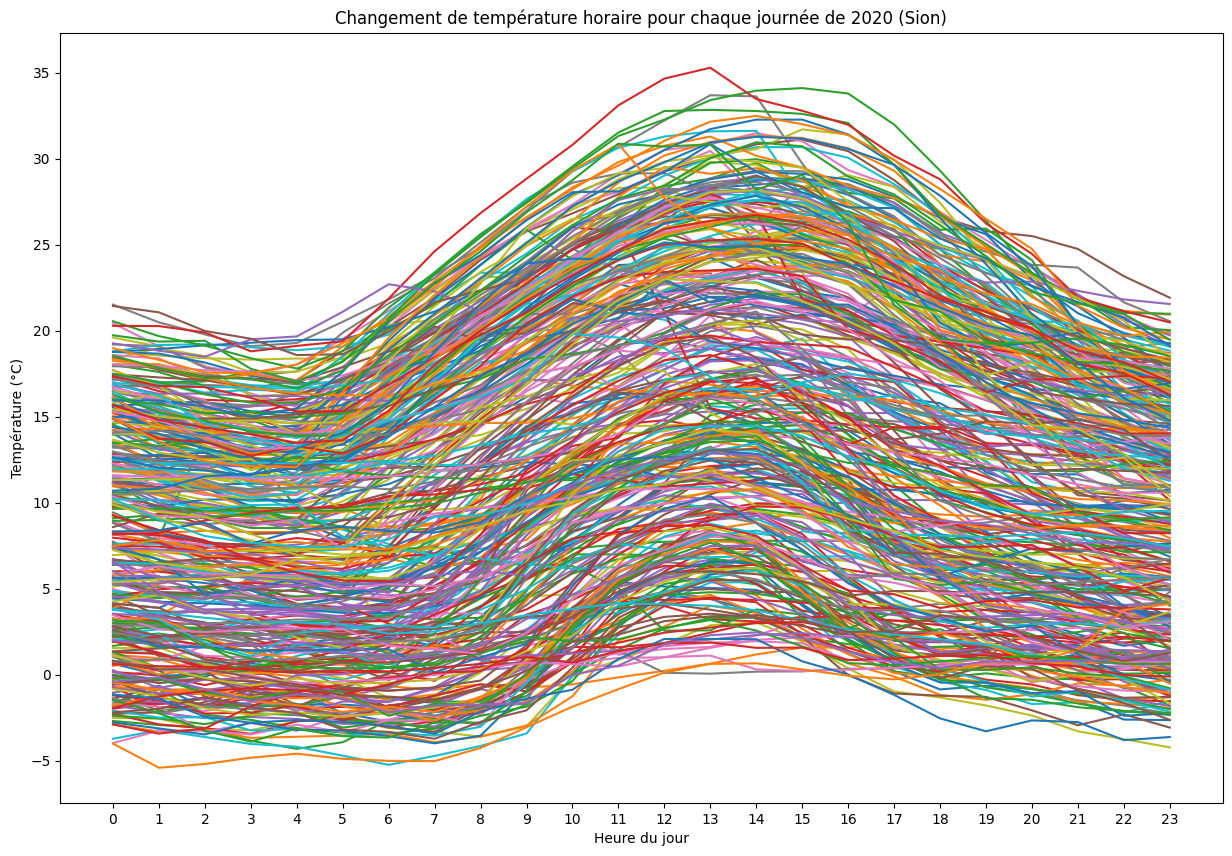

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

data_renamed['date'] = pd.to_datetime(data_renamed['date'])

# Filtrer les données pour Sion et pour l'année 2020
data_sion_2020 = data_renamed[(data_renamed['station_name'] == 'Sion') & (data_renamed['date'].dt.year == 2020)]

# Extraire le jour à partir de la colonne 'date' pour le regroupement
data_sion_2020['day'] = data_sion_2020['date'].dt.date

# Grouper les données par jour et par heure et calculer la moyenne pour chaque heure
grouped = data_sion_2020.groupby(['day', 'hour'])['temperature_2m'].mean().reset_index()

# Pivoter les données pour faciliter le tracé
pivot_data = grouped.pivot(index='day', columns='hour', values='temperature_2m')

plt.figure(figsize=(15, 10))
for day, row in pivot_data.iterrows():
    plt.plot(range(24), row, label=f'{day}')

plt.title('Changement de température horaire pour chaque journée de 2020 (Sion)')
plt.xlabel('Heure du jour')
plt.ylabel('Température (°C)')
plt.xticks(range(24))  
plt.show()


Chaque courbe représente les températures moyennes horaires pour la ville de Sion

In [13]:
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans

time_series_data = to_time_series_dataset(pivot_data.fillna(method='ffill').values)


C:\Users\Abdi\AppData\Local\Temp\ipykernel_3340\360013435.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series_data = to_time_series_dataset(pivot_data.fillna(method='ffill').values)


In [14]:
# Définir le modèle de clustering
n_clusters = 4 
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=33)
labels = model.fit_predict(time_series_data)

# Afficher les étiquettes des clusters pour chaque série temporelle
print("Labels des clusters:", labels)


Labels des clusters: [0 2 2 2 2 3 1 1 3 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 3 1
 1 1 3 3 3 0 0 2 2 2 2 2 0 2 2 2 2 2 2 0 0 0 2 0 2 2 2 2 1 3 3 3 2 3 0 2 2
 2 2 2 3 3 3 3 2 2 2 0 2 2 3 2 2 2 0 2 2 2 3 3 1 3 3 3 2 0 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 2 0 0 0 3 3 3 1 3 1 2 2 0 3 3 3 3 3 3 1 1 1 1 3 3 3 3 3
 3 3 3 3 0 0 2 3 3 3 1 1 3 2 2 0 3 3 1 1 3 3 3 3 1 1 1 1 1 1 1 1 1 1 0 0 2
 3 3 3 1 1 3 2 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 3 3 3 1 1 3
 2 2 0 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 3 3 3 3 0 2 2 3 1 3 1 1 1 2 2 0 1 1 1
 1 1 1 3 1 3 3 3 3 2 2 2 2 2 3 0 2 0 3 1 3 1 1 1 2 2 0 2 2 2 2 2 2 2 2 3 3
 3 2 2 2 2 2 2 2 2 0 2 2 3 3 3 1 1 1 2 2 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0
 0 0 0 2 2 3 2 3 1 1 1 2 2 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0]


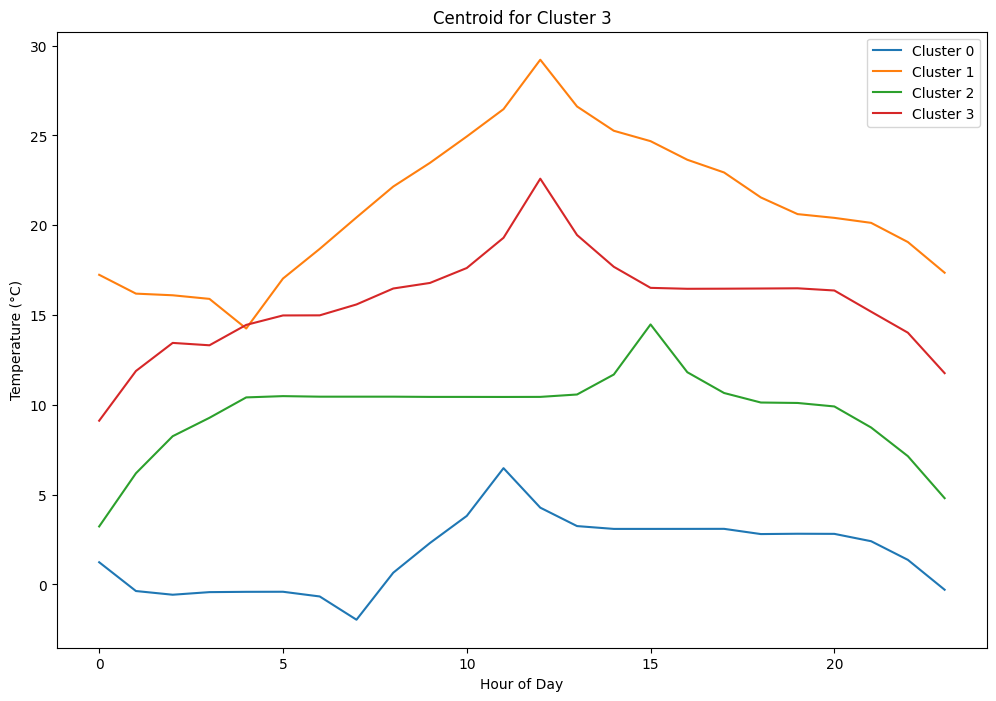

In [15]:
import matplotlib.pyplot as plt

# Afficher les centroids des clusters
plt.figure(figsize=(12, 8))
for i in range(n_clusters):
    plt.plot(model.cluster_centers_[i].ravel(), label=f'Cluster {i}')
    plt.title(f'Centroid for Cluster {i}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Temperature (°C)')

plt.legend()
plt.show()


Ce graph permet de comprendre comment les températures varient typiquement tout au long de la journée pour différents types de jours météorologiques à Sion en 2020. Chaque cluster peut révéler un type différent de dynamique diurne, comme des jours plus chauds, des jours plus froids, ou des jours avec des changements de température importants.

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

372.518 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.0s


294.680 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.0s


288.213 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.0s


286.547 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.0s


286.116 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.0s


285.798 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.0s


285.476 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.0s


285.357 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.0s


285.159 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.0s


284.907 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.0s


284.347 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s


283.752 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s


283.711 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.0s


282.333 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.0s


282.074 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.0s


282.074 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.0s


Labels des clusters : [0 3 3 0 0 0 0 3 3 3 3 0 0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0
 0 2 2 2 0 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 0 2 2 2 2 2 2
 0 2 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 3 0 0 3 0 0 0 3 3 0 3 3 0
 3 3 3 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 1 1 1 1 1 3 1 1 1 1 3 3 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 3 1 1 1 1 3 3 1 1 1 1 1
 3 1 3 1 1 3 1 3 3 3 3 3 3 3 3 3 3 3 1 1 3 3 3 3 3 3 3 3 0 3 3 3 3]


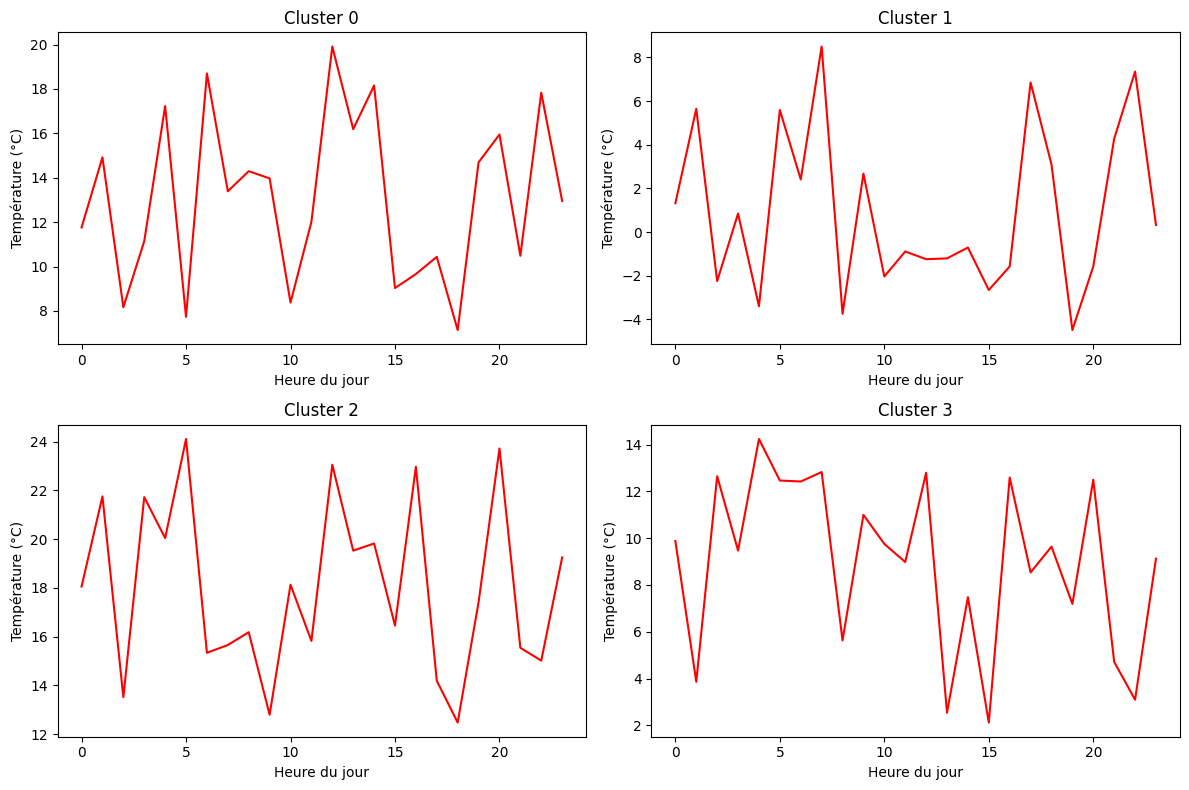

In [16]:
import pandas as pd
import numpy as np
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt

np.random.seed(0)
dates = pd.date_range(start='2020-01-01', periods=366 * 24, freq='H')
temperatures = np.random.normal(loc=10, scale=5, size=366 * 24) 

data_sion = pd.DataFrame({
    'date': dates,
    'temperature_2m': temperatures + 10 * np.sin(np.linspace(0, 24, 366 * 24) * np.pi / 12)  # Variation diurne
})
data_sion['day'] = data_sion['date'].dt.date

daily_temperatures = data_sion.groupby('day')['temperature_2m'].apply(list)

# Convertir en un ensemble de données de série temporelle pour tslearn
formatted_dataset = to_time_series_dataset(list(daily_temperatures))
model = TimeSeriesKMeans(n_clusters=4, metric="dtw", verbose=True, random_state=33)
labels = model.fit_predict(formatted_dataset)
print("Labels des clusters :", labels)
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(model.cluster_centers_[i].ravel(), "r-")
    plt.title(f"Cluster {i}")
    plt.xlabel("Heure du jour")
    plt.ylabel("Température (°C)")
plt.tight_layout()
plt.show()


<br>-Cluster 0  représente des jours où la température reste relativement élevée,ce qui pourrait être typique d'une journée chaude et stable.
<br>-Cluster 1 montre des températures modérées avec des pics et des creux plus marqués
<br>-Cluster 2 semble illustrer des jours où la température reste plus constante et relativement plus basse, ce qui pourrait caractériser une journée froide.
<br>-Cluster 3 a des températures encore plus basses et une grande variabilité, peut-être des jours de transition entre des périodes climatiques ou des jours avec des événements météorologiques particuliers.

C:\Users\Abdi\AppData\Local\Temp\ipykernel_3340\1015968408.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sion_2020['day'] = data_sion_2020['date'].dt.date


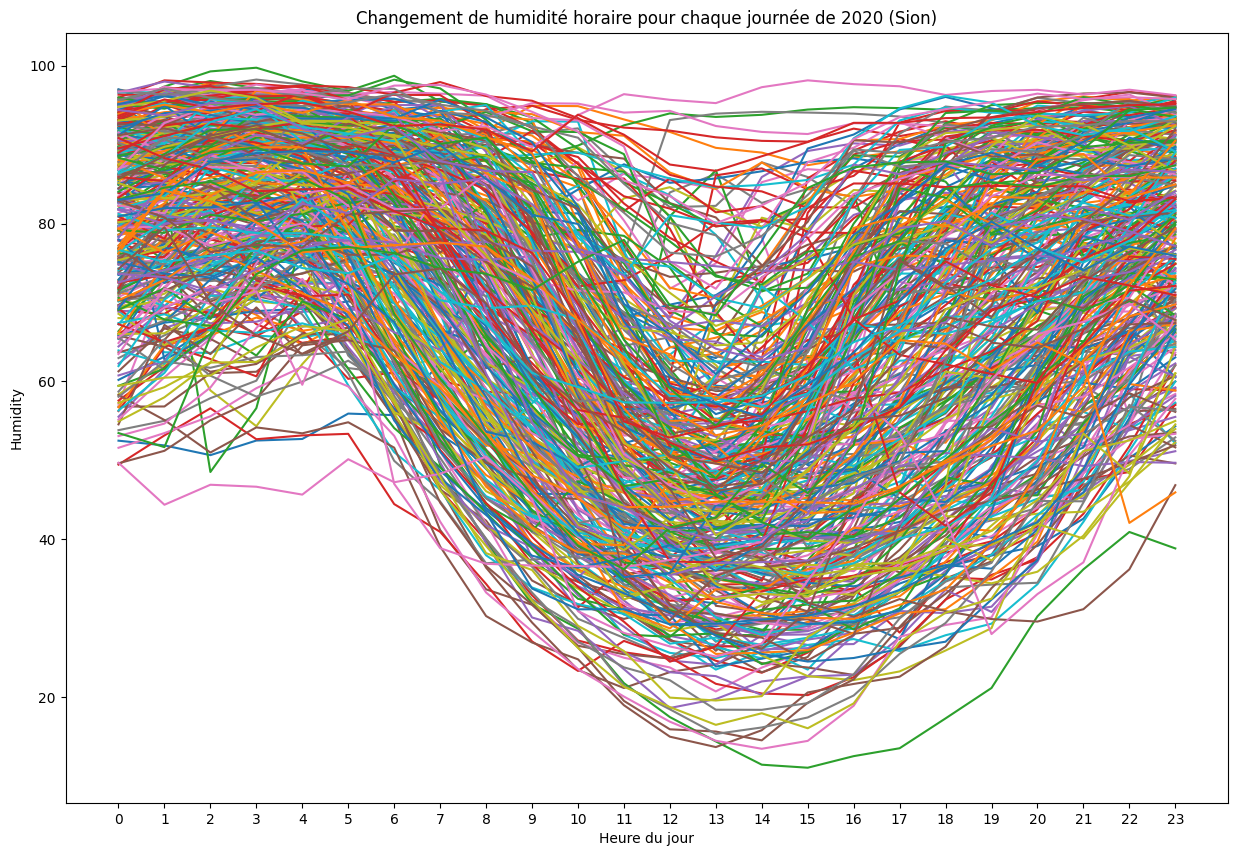

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

data_renamed['date'] = pd.to_datetime(data_renamed['date'])
data_sion_2020 = data_renamed[(data_renamed['station_name'] == 'Sion') & (data_renamed['date'].dt.year == 2020)]
data_sion_2020['day'] = data_sion_2020['date'].dt.date
grouped1 = data_sion_2020.groupby(['day', 'hour'])['humidity_2m'].mean().reset_index()

# Pivoter les données pour faciliter le tracé
pivot_data = grouped1.pivot(index='day', columns='hour', values='humidity_2m')

# Tracer les courbes de température pour chaque jour
plt.figure(figsize=(15, 10))
for day, row in pivot_data.iterrows():
    plt.plot(range(24), row, label=f'{day}')

plt.title('Changement de humidité horaire pour chaque journée de 2020 (Sion)')
plt.xlabel('Heure du jour')
plt.ylabel('Humidity')
plt.xticks(range(24)) 
plt.show()


C:\Users\Abdi\AppData\Local\Temp\ipykernel_3340\4226481403.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series_data = to_time_series_dataset(pivot_data.fillna(method='ffill').values)  # Utiliser ffill pour gérer les NaN si nécessaire


Labels des clusters: [3 3 1 2 3 2 1 1 1 3 1 3 2 2 2 2 1 1 2 0 0 2 1 3 1 1 1 3 1 1 3 3 3 1 0 3 2
 1 1 1 1 1 3 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 1 2 0 1 2 2 3 1 1 3 1 1 2
 2 0 2 2 2 0 2 1 1 2 2 0 2 0 2 2 0 3 1 2 0 2 3 2 1 1 1 1 1 0 0 0 0 0 2 2 2
 1 0 0 0 0 1 1 3 1 3 3 2 1 0 3 1 2 1 1 1 3 3 3 1 1 1 2 2 2 0 2 0 1 2 2 2 0
 0 0 2 2 1 2 2 0 1 1 0 1 2 3 1 3 1 1 2 2 1 1 2 2 0 2 2 2 2 2 0 1 1 2 1 2 0
 0 2 1 0 2 2 1 1 3 2 0 0 2 2 2 2 2 2 1 1 1 2 2 2 1 1 1 2 1 2 2 0 2 1 2 2 1
 1 1 1 1 1 1 1 1 1 2 2 0 0 0 0 2 2 2 1 3 3 1 1 2 2 0 2 1 2 2 1 1 1 3 1 1 2
 1 1 1 1 1 3 1 1 3 1 1 1 1 3 3 3 0 3 0 2 3 2 1 1 3 1 1 1 1 3 1 1 1 1 2 2 1
 3 3 1 3 1 1 3 1 1 1 0 1 0 2 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1
 3 3 2 0 1 0 1 2 1 1 1 1 1 3 3 3 3 3 1 1 1 3 3 3 3 1 1 1 0 3 3 3 2]


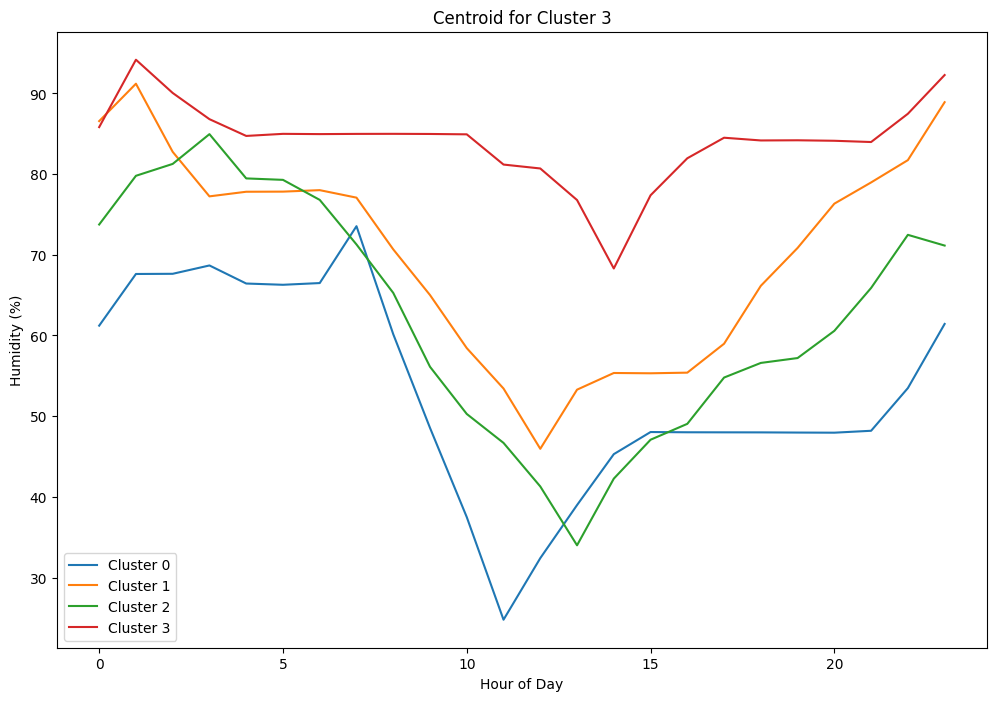

In [18]:
from tslearn.utils import to_time_series_dataset
time_series_data = to_time_series_dataset(pivot_data.fillna(method='ffill').values)  # Utiliser ffill pour gérer les NaN si nécessaire
from tslearn.clustering import TimeSeriesKMeans
import numpy as np

n_clusters = 4 
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=33)
labels = model.fit_predict(time_series_data)
print("Labels des clusters:", labels)
import matplotlib.pyplot as plt

# Afficher les centroids des clusters
plt.figure(figsize=(12, 8))
for i in range(n_clusters):
    plt.plot(model.cluster_centers_[i].ravel(), label=f'Cluster {i}')
    plt.title(f'Centroid for Cluster {i}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Humidity (%)')

plt.legend()
plt.show()


C:\Users\Abdi\AppData\Local\Temp\ipykernel_3340\3543754024.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sion_2020['day'] = data_sion_2020['date'].dt.date


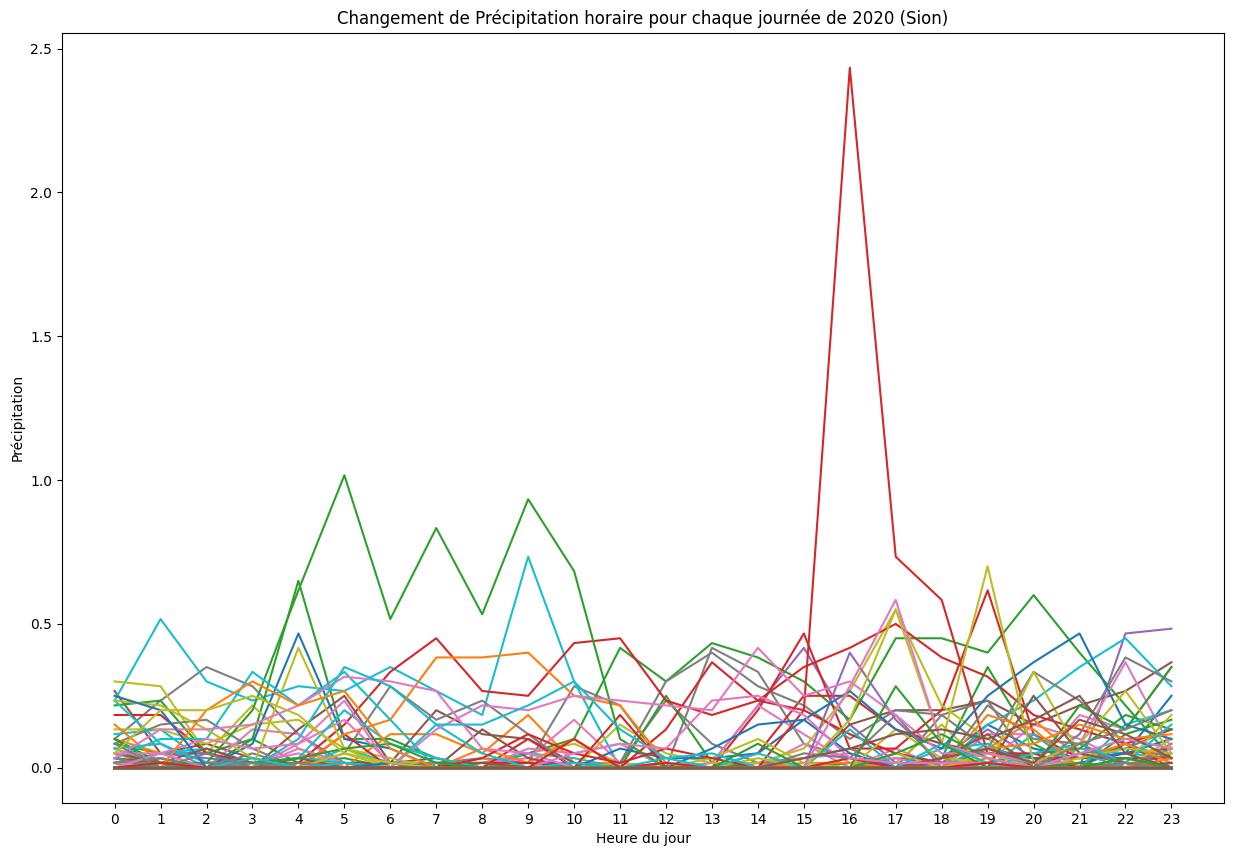

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

data_renamed['date'] = pd.to_datetime(data_renamed['date'])
data_sion_2020 = data_renamed[(data_renamed['station_name'] == 'Sion') & (data_renamed['date'].dt.year == 2020)]
data_sion_2020['day'] = data_sion_2020['date'].dt.date
grouped2 = data_sion_2020.groupby(['day', 'hour'])['precipitation_1h'].mean().reset_index()
pivot_data = grouped2.pivot(index='day', columns='hour', values='precipitation_1h')
plt.figure(figsize=(15, 10))
for day, row in pivot_data.iterrows():
    plt.plot(range(24), row, label=f'{day}')

plt.title('Changement de Précipitation horaire pour chaque journée de 2020 (Sion)')
plt.xlabel('Heure du jour')
plt.ylabel('Précipitation')
plt.xticks(range(24)) 
plt.show()


Labels des clusters: [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 2 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


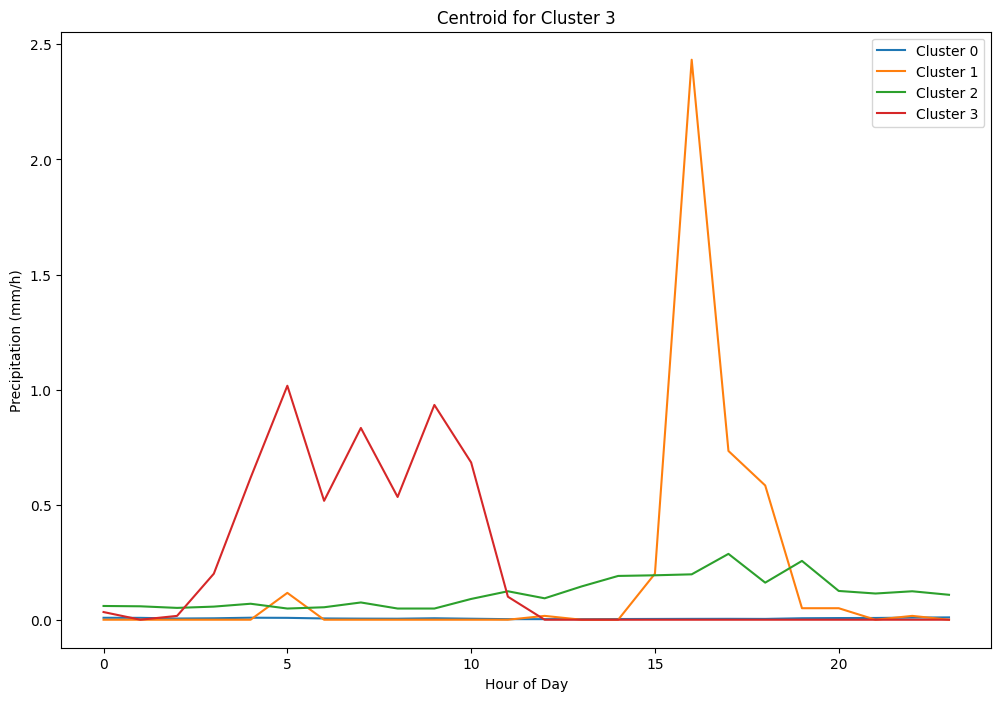

In [20]:
from tslearn.utils import to_time_series_dataset
pivot_data_filled = pivot_data.fillna(0)
time_series_data = to_time_series_dataset(pivot_data_filled)
from tslearn.clustering import TimeSeriesKMeans

n_clusters = 4 
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", random_state=33)
labels = model.fit_predict(time_series_data)

# Afficher les étiquettes des clusters pour chaque série temporelle
print("Labels des clusters:", labels)

import matplotlib.pyplot as plt

# Afficher les centroids des clusters
plt.figure(figsize=(12, 8))
for i in range(n_clusters):
    plt.plot(model.cluster_centers_[i].ravel(), label=f'Cluster {i}')
    plt.title(f'Centroid for Cluster {i}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Precipitation (mm/h)')

plt.legend()
plt.show()


Ce graph permets de découvrir des groupes de jours ayant des profils de précipitation similaires.

<span style="text-align:center;color: Aqua; font-size: 34px;bold; ">Partie 2 :Interprétation par LLM </span><br>
<br>

In [21]:
def generate_cluster_description(df, cluster_column):
    cluster_descriptions = []
    num_clusters = df[cluster_column].nunique()

    for cluster in sorted(df[cluster_column].unique()):
        cluster_data = df[df[cluster_column] == cluster]
        # Supposons que vous avez des colonnes telles que 'temperature' et 'humidity'
        mean_temp = cluster_data['temperature'].mean()
        mean_humidity = cluster_data['humidity'].mean()
        description = (f"Cluster {cluster} includes data points with an average temperature of {mean_temp:.1f}°C "
                       f"and an average humidity of {mean_humidity:.1f}%. ")
        cluster_descriptions.append(description)

    full_description = " ".join(cluster_descriptions)
    return f"The clustering resulted in {num_clusters} clusters. {full_description}"


In [22]:
print(data.columns)  # Ceci affichera les noms de toutes les colonnes dans le DataFrame 'data'


Index(['stn', 'xchills0', 'gre000z0', 'prestas0', 'tre200s0', 'rre150z0',
       'ure200s0', 'sre000z0', 'fu3010z0', 'dkl010z0', 'year', 'day_of_year',
       'minute_of_day', 'name', 'longitude', 'latitude', 'km_longitude',
       'km_latitude', 'altitude', 'hour_of_day', 'month_day', 'date_ddmmyy'],
      dtype='object')


In [23]:
# Filtrer pour la ville de Sion et l'année 2020
sion_temperatures_2020 = data_renamed[(data_renamed['station_name'] == 'Sion') & (data_renamed['year'] == 2020)]

# Sélectionner uniquement les colonnes de date et de température
sion_temperatures = sion_temperatures_2020[['date', 'temperature_2m']]

# Afficher les résultats
print(sion_temperatures)


              date  temperature_2m
3925872 2020-01-01            -0.9
3925873 2020-01-01            -1.2
3925874 2020-01-01            -1.8
3925875 2020-01-01            -1.7
3925876 2020-01-01            -1.3
...            ...             ...
3978571 2020-12-31             1.4
3978572 2020-12-31             1.2
3978573 2020-12-31             1.3
3978574 2020-12-31             1.2
3978575 2020-12-31             1.3

[52704 rows x 2 columns]


In [24]:
import pandas as pd

data_sion_jan1 = data_renamed[(data_renamed['station_name'] == 'Sion') & 
                              (data_renamed['date'] == '01/01/20')]

# Afficher les valeurs de température pour cette journée
print(data_sion_jan1[['date', 'temperature_2m']])


              date  temperature_2m
3925872 2020-01-01            -0.9
3925873 2020-01-01            -1.2
3925874 2020-01-01            -1.8
3925875 2020-01-01            -1.7
3925876 2020-01-01            -1.3
...            ...             ...
3926011 2020-01-01            -2.8
3926012 2020-01-01            -3.0
3926013 2020-01-01            -2.9
3926014 2020-01-01            -2.6
3926015 2020-01-01            -2.3

[144 rows x 2 columns]


In [25]:
import pandas as pd

data_renamed['date'] = pd.to_datetime(data_renamed['date'], format='%d/%m/%y')

# Filtrer pour obtenir les données pour Sion le 1er janvier 2020
sion_jan1_2020 = data_renamed[(data_renamed['station_name'] == 'Sion') & (data_renamed['date'] == '2020-01-01')]

# Extraire les températures
temperatures_sion_jan1 = sion_jan1_2020['temperature_2m'].tolist()
print("Temperatures for Sion on January 1st, 2020:", temperatures_sion_jan1)


Temperatures for Sion on January 1st, 2020: [-0.9, -1.2, -1.8, -1.7, -1.3, -1.5, -1.0, -1.7, 0.3, 0.4, -0.9, -0.9, -1.3, -1.6, -2.8, -0.9, -2.2, -2.7, -1.2, -2.7, -1.8, -2.0, -0.8, -1.2, -1.0, -0.5, -0.4, -0.9, -1.4, -1.5, -1.7, -2.3, -1.4, -2.5, -3.3, -2.2, -2.4, -2.3, -2.5, -2.7, -3.2, -3.2, -2.7, -2.8, -2.2, -2.6, -1.6, -1.1, -2.1, -1.8, -1.7, -1.8, -2.3, -1.9, -1.7, -1.7, -1.8, -1.9, -1.7, -1.1, -0.9, -1.1, -0.2, -0.2, 0.7, 1.9, 2.2, 1.5, 3.2, 3.0, 3.6, 4.1, 4.3, 4.4, 5.2, 4.8, 4.6, 4.4, 4.5, 3.7, 4.6, 4.5, 4.5, 4.6, 4.4, 3.7, 3.7, 3.3, 3.4, 3.5, 3.3, 3.1, 2.6, 2.3, 1.5, 1.8, 1.6, 1.5, 1.2, 1.2, 1.1, 0.7, 0.5, 0.6, 0.0, 0.3, 0.0, -0.2, -0.4, -0.5, -1.3, -0.7, -0.5, -1.7, -1.1, -0.9, -0.9, -0.5, -0.6, 0.2, 0.1, -0.9, -0.9, -1.2, -1.3, -0.6, -0.7, -1.7, -1.7, -1.3, -2.0, -1.7, -3.2, -1.9, -2.2, -2.9, -2.3, -3.1, -2.2, -2.8, -3.0, -2.9, -2.6, -2.3]


In [26]:
# Convertir la liste de températures en une chaîne de caractères
temperature_string = ', '.join(map(str, temperatures_sion_jan1))
print("Formatted temperature string for API or prompt use:", temperature_string)


Formatted temperature string for API or prompt use: -0.9, -1.2, -1.8, -1.7, -1.3, -1.5, -1.0, -1.7, 0.3, 0.4, -0.9, -0.9, -1.3, -1.6, -2.8, -0.9, -2.2, -2.7, -1.2, -2.7, -1.8, -2.0, -0.8, -1.2, -1.0, -0.5, -0.4, -0.9, -1.4, -1.5, -1.7, -2.3, -1.4, -2.5, -3.3, -2.2, -2.4, -2.3, -2.5, -2.7, -3.2, -3.2, -2.7, -2.8, -2.2, -2.6, -1.6, -1.1, -2.1, -1.8, -1.7, -1.8, -2.3, -1.9, -1.7, -1.7, -1.8, -1.9, -1.7, -1.1, -0.9, -1.1, -0.2, -0.2, 0.7, 1.9, 2.2, 1.5, 3.2, 3.0, 3.6, 4.1, 4.3, 4.4, 5.2, 4.8, 4.6, 4.4, 4.5, 3.7, 4.6, 4.5, 4.5, 4.6, 4.4, 3.7, 3.7, 3.3, 3.4, 3.5, 3.3, 3.1, 2.6, 2.3, 1.5, 1.8, 1.6, 1.5, 1.2, 1.2, 1.1, 0.7, 0.5, 0.6, 0.0, 0.3, 0.0, -0.2, -0.4, -0.5, -1.3, -0.7, -0.5, -1.7, -1.1, -0.9, -0.9, -0.5, -0.6, 0.2, 0.1, -0.9, -0.9, -1.2, -1.3, -0.6, -0.7, -1.7, -1.7, -1.3, -2.0, -1.7, -3.2, -1.9, -2.2, -2.9, -2.3, -3.1, -2.2, -2.8, -3.0, -2.9, -2.6, -2.3


In [27]:
prompt = f"Analyze the following hourly temperatures for Sion on January 1st, 2020: {temperature_string}. What insights can you provide about the weather patterns on this day?"


<span style="color: Green; font-size: 24px;bold"> Intégration de ChatGPT pour l'analyse et l'interprétation de séries temporelles</span>

In [28]:
import requests
import os  # Importation de la bibliothèque os

def call_chatgpt(prompt):
    api_key = os.getenv('OPENAI_API_KEY')  # Lecture de la clé API depuis une variable d'environnement
    if not api_key:
        raise ValueError("API key is not set. Please set the OPENAI_API_KEY environment variable.")

    url = "https://api.openai.com/v1/chat/completions"
    headers = {
        'Authorization': f'Bearer {api_key}',
        'Content-Type': 'application/json'
    }
    payload = {
        'model': 'gpt-3.5-turbo',  # Modification du modèle à gpt-3.5-turbo
        'messages': [{
            'role': 'user',
            'content': prompt
        }]
    }
    response = requests.post(url, headers=headers, json=payload)
    if response.status_code == 200:
        return response.json()['choices'][0]['message']['content']
    else:
        return f"Error {response.status_code}: {response.text}"

# Test de la fonction
prompt = "What is the capital of Turkey?"
result = call_chatgpt(prompt)
print(result)



The capital of Turkey is Ankara.


<span style="color: Green; font-size: 20px;bold"> Interprétation de la température à Sion le 1er janvier 2020.</span>

In [29]:
prompt = prompt = f"Analyze the following hourly temperatures for Sion on January 1st, 2020: {temperature_string}. What insights can you provide about the weather patterns on this day?"
result = call_chatgpt(prompt)
print(result)

This data represents a typical winter day in Sion, a city in Switzerland, characterized by subzero temperatures. Here are some insights we can draw from the data:

1. Coldest Hours: The coldest temperature recorded on this day was -3.3 degree Celsius. This temperature was observed once during the first 24 hours of the day, indicating that it might be during the wee hours of the morning or late evening that such frigid temperatures were experienced.

2. Warmest Hours: The highest temperature recorded was 5.2 degrees Celsius. These mildly warmer temperatures were observed mostly during the latter part of the data series, indicating that the afternoon or early evening might have been the warmest period of the day.

3. Overall Temperature Range: The comprehensive temperature range for January 1st, 2020, in Sion was between -3.3 and 5.2 degrees Celsius.

4. Temperature Fluctuation: There were fluctuating temperatures throughout the course of the day. However, a noticeable pattern is the gra

<span style="color: Green; font-size: 20px;bold"> Interprétation de la température à Sion le 1er juin 2020.</span>

In [52]:
import pandas as pd
data_renamed['date'] = pd.to_datetime(data_renamed['date'], format='%d/%m/%y')

# Filtrer pour obtenir les données pour Sion le 1er janvier 2020
sion_juin1_2020 = data_renamed[(data_renamed['station_name'] == 'Sion') & (data_renamed['date'] == '01-06-20')]

# Extraire les températures
temperatures_sion_juin1 = sion_juin1_2020['temperature_2m'].tolist()
print("Temperatures for Sion on Juin 1st, 2020:", temperatures_sion_juin1)

Temperatures for Sion on Juin 1st, 2020: [12.5, 12.3, 13.5, 12.1, 12.6, 12.7, 12.1, 12.3, 12.1, 11.7, 11.9, 11.6, 11.8, 12.1, 11.1, 11.6, 11.0, 11.6, 11.7, 11.1, 10.9, 11.6, 11.8, 12.5, 12.4, 11.1, 11.3, 12.2, 12.5, 12.7, 13.1, 13.4, 13.8, 13.9, 14.2, 14.6, 14.7, 15.0, 15.4, 15.8, 16.2, 16.6, 16.8, 17.2, 17.5, 17.6, 18.0, 19.0, 19.0, 19.5, 20.2, 19.8, 20.2, 21.1, 21.1, 22.2, 22.1, 22.6, 22.1, 22.4, 23.5, 22.2, 22.9, 23.2, 23.1, 25.1, 26.1, 25.0, 25.0, 25.1, 24.9, 25.6, 25.8, 25.1, 25.5, 26.1, 26.4, 25.4, 25.0, 24.9, 24.8, 24.5, 24.8, 24.9, 25.3, 25.2, 25.0, 25.1, 25.4, 25.2, 25.4, 25.2, 25.3, 25.3, 25.3, 25.6, 25.2, 25.2, 25.1, 25.0, 25.0, 24.9, 24.9, 25.0, 24.6, 24.3, 24.0, 23.7, 23.5, 23.1, 22.9, 22.7, 22.5, 21.8, 21.8, 21.3, 20.8, 20.8, 21.0, 21.0, 20.0, 20.0, 20.3, 19.7, 20.1, 18.6, 19.8, 19.6, 19.0, 19.7, 17.9, 19.1, 18.5, 17.8, 17.5, 17.3, 16.7, 17.5, 16.5, 15.9, 15.9, 16.1, 16.8, 16.8]


In [53]:
# Convertir la liste de températures en une chaîne de caractères
temperature_string = ', '.join(map(str, temperatures_sion_juin1))
print("Formatted temperature string for API or prompt use:", temperature_string)

Formatted temperature string for API or prompt use: 12.5, 12.3, 13.5, 12.1, 12.6, 12.7, 12.1, 12.3, 12.1, 11.7, 11.9, 11.6, 11.8, 12.1, 11.1, 11.6, 11.0, 11.6, 11.7, 11.1, 10.9, 11.6, 11.8, 12.5, 12.4, 11.1, 11.3, 12.2, 12.5, 12.7, 13.1, 13.4, 13.8, 13.9, 14.2, 14.6, 14.7, 15.0, 15.4, 15.8, 16.2, 16.6, 16.8, 17.2, 17.5, 17.6, 18.0, 19.0, 19.0, 19.5, 20.2, 19.8, 20.2, 21.1, 21.1, 22.2, 22.1, 22.6, 22.1, 22.4, 23.5, 22.2, 22.9, 23.2, 23.1, 25.1, 26.1, 25.0, 25.0, 25.1, 24.9, 25.6, 25.8, 25.1, 25.5, 26.1, 26.4, 25.4, 25.0, 24.9, 24.8, 24.5, 24.8, 24.9, 25.3, 25.2, 25.0, 25.1, 25.4, 25.2, 25.4, 25.2, 25.3, 25.3, 25.3, 25.6, 25.2, 25.2, 25.1, 25.0, 25.0, 24.9, 24.9, 25.0, 24.6, 24.3, 24.0, 23.7, 23.5, 23.1, 22.9, 22.7, 22.5, 21.8, 21.8, 21.3, 20.8, 20.8, 21.0, 21.0, 20.0, 20.0, 20.3, 19.7, 20.1, 18.6, 19.8, 19.6, 19.0, 19.7, 17.9, 19.1, 18.5, 17.8, 17.5, 17.3, 16.7, 17.5, 16.5, 15.9, 15.9, 16.1, 16.8, 16.8


In [54]:
prompt = f"Analyze the following hourly temperatures for Sion on Juin 1st, 2020: {temperature_string}. What insights can you provide about the weather patterns on this day?"
result = call_chatgpt(prompt)
print(result)


The data represents hourly temperatures for Sion on June 1st, 2020. Here are a few insights about the day's weather pattern:

1. Temperature Fluctuation: The temperature fluctuated throughout the day from a low of 10.9 to a high of 26.4.

2. Temperature Increase: There seems to be a relatively steady increase in temperature from the early hours of the day until the afternoon. This pattern is typically because the sun shares the most heat at these times.

3. Midday Peak: The highest temperature of 26.4 occurred likely in the afternoon, indicative of the midday peak in temperatures.

4. Evening Cooling: There's a gradual reduction in temperature during the evening hours, likely due to the sun setting.

5. Night Temperatures: The temperature decreased significantly during the night, but remained above 10.9. This suggests that it was a relatively mild night. 

6. Overall, the day seems to have had relatively typical weather, with a gradual warming to a peak in the afternoon, followed by a 

<span style="color: Green; font-size: 20px;bold"> Interprétation de la température moyenne mensuelle à Sion durant l'année 2020.</span>

In [33]:
import pandas as pd
data_renamed['date'] = pd.to_datetime(data_renamed['date'])

# Filtrez les données pour l'année 2020
data_2020 = data_renamed[data_renamed['date'].dt.year == 2020]

# Groupez les données par mois et calculez la moyenne de la température
monthly_avg_temperatures = data_2020.groupby(data_2020['date'].dt.month)['temperature_2m'].mean()

# Affichez les résultats
print(monthly_avg_temperatures)


date
1      4.701408
2      6.963129
3      6.910772
4     10.943946
5     12.076514
6     13.696195
7     15.305090
8     14.846429
9     12.966083
10     9.091209
11     6.091865
12     5.285501
Name: temperature_2m, dtype: float64


In [34]:
import pandas as pd

data_renamed['date'] = pd.to_datetime(data_renamed['date'])

# Filtrer pour obtenir les données pour Sion durant l'année 2020
sion_2020 = data_renamed[(data_renamed['station_name'] == 'Sion') & (data_renamed['date'].dt.year == 2020)]

# Grouper par mois et calculer la moyenne des températures
monthly_avg_temperatures = sion_2020.groupby(sion_2020['date'].dt.month)['temperature_2m'].mean()

# Extraire les températures moyennes mensuelles et les convertir en une chaîne de caractères
temperatures_str = ", ".join(f"{month}: {temp:.1f}°C" for month, temp in monthly_avg_temperatures.items())
print("Monthly average temperatures for Sion in 2020:", temperatures_str)

# Créer un prompt pour analyse ou usage API
prompt = (f"Analyze the following monthly average temperatures for Sion during the year 2020: {temperatures_str}. "
          "What insights can you provide about the climatic variations throughout the year?")
result = call_chatgpt(prompt)
print(result)


Monthly average temperatures for Sion in 2020: 1: 5.3°C, 2: 8.2°C, 3: 9.5°C, 4: 13.4°C, 5: 14.9°C, 6: 16.6°C, 7: 17.6°C, 8: 16.8°C, 9: 14.3°C, 10: 10.4°C, 11: 6.7°C, 12: 5.9°C
The data provided captures the monthly average temperatures for Sion throughout the year 2020. From these details, we can identify certain trends and key points in the city's climate.

1. Winter Temperatures: The coldest months appear to be January and December with temperatures of 5.3°C and 5.9°C, respectively. This implies a typical winter season where the temperature drops to low levels.

2. Summer Temperatures: The warmest months of the year are July and August, as expected in a temperate climate, with average temperatures of 17.6°C and 16.8°C, respectively. This indicates a traditional summer period with relatively mild temperatures, given the location.

3. Transition Seasons: Spring appears to start mild with an average temperature of 9.5°C in March, gradually increasing to 14.9°C by May. Similarly, fall be

<span style="color: Green; font-size: 20px;bold"> Interprétation de la humidité à Sion le 1er janvier 2020.</span>

In [35]:
import pandas as pd
data_renamed['date'] = pd.to_datetime(data_renamed['date'])

# Filtrer pour obtenir les données pour Sion le 1er janvier 2020
sion_jan1_2020 = data_renamed[(data_renamed['station_name'] == 'Sion') & (data_renamed['date'] == '2020-01-01')]

# Extraire les valeurs d'humidité
humidity_sion_jan1 = sion_jan1_2020['humidity_2m'].tolist()
print("Humidity values for Sion on January 1st, 2020:", humidity_sion_jan1)

# Convertir la liste d'humidité en une chaîne de caractères
humidity_string = ', '.join(map(str, humidity_sion_jan1))
print("Formatted humidity string for API or prompt use:", humidity_string)

# Créer un prompt pour analyse ou usage API
prompt = f"Analyze the following hourly humidity values for Sion on January 1st, 2020: {humidity_string}. " \
         "What insights can you provide about the moisture levels on this day?"
result = call_chatgpt(prompt)  
print(result)


Humidity values for Sion on January 1st, 2020: [90.9, 91.0, 92.4, 92.9, 91.6, 92.0, 89.9, 91.9, 86.7, 87.0, 91.1, 90.2, 89.6, 90.9, 95.9, 89.4, 94.3, 94.9, 90.4, 95.3, 92.9, 92.4, 88.5, 90.1, 89.2, 87.2, 87.2, 89.1, 88.8, 89.5, 90.1, 91.9, 89.4, 93.7, 93.7, 90.4, 93.0, 93.7, 92.3, 92.6, 92.4, 91.5, 91.4, 92.7, 90.0, 91.1, 88.7, 87.0, 89.8, 89.4, 88.8, 88.8, 91.3, 89.0, 87.2, 87.8, 88.5, 88.3, 87.6, 85.2, 84.5, 86.8, 84.9, 87.6, 86.9, 83.3, 83.5, 82.6, 75.4, 74.5, 71.2, 71.0, 68.3, 64.8, 68.2, 63.1, 60.7, 61.3, 62.2, 65.8, 61.7, 63.1, 62.4, 62.6, 62.9, 66.3, 66.3, 69.8, 69.6, 70.3, 73.9, 75.4, 78.6, 80.1, 83.6, 83.9, 85.1, 85.4, 86.9, 86.8, 88.2, 89.5, 89.9, 89.4, 91.7, 88.7, 89.9, 90.9, 90.7, 92.4, 93.6, 92.6, 91.1, 94.3, 90.2, 89.6, 91.0, 89.2, 90.3, 88.5, 88.4, 89.1, 88.7, 90.8, 91.5, 88.3, 88.5, 91.4, 89.6, 89.0, 92.0, 92.2, 94.0, 91.0, 90.8, 92.9, 90.6, 93.9, 92.6, 93.9, 95.8, 93.2, 93.1, 91.9]
Formatted humidity string for API or prompt use: 90.9, 91.0, 92.4, 92.9, 91.6, 92.0, 89.

<span style="color: Green; font-size: 20px;bold"> Interprétation de la humidité moyenne mensuelle à Sion durant l'année 2020.</span>

In [36]:
import pandas as pd

data_renamed['date'] = pd.to_datetime(data_renamed['date'])

# Filtrer pour obtenir les données pour Sion durant l'année 2020
sion_2020 = data_renamed[(data_renamed['station_name'] == 'Sion') & (data_renamed['date'].dt.year == 2020)]

# Grouper par mois et calculer la moyenne de l'humidité
monthly_avg_humidity = sion_2020.groupby(sion_2020['date'].dt.month)['humidity_2m'].mean()

# Extraire les valeurs moyennes d'humidité et les convertir en une chaîne de caractères
humidity_str = ", ".join(f"{month}: {humidity:.1f}%" for month, humidity in monthly_avg_humidity.items())
print("Monthly average humidity values for Sion in 2020:", humidity_str)

# Créer un prompt pour analyse ou usage API
prompt = (f"Analyze the following monthly average humidity values for Sion during the year 2020: {humidity_str}. "
          "What insights can you provide about the moisture levels and climatic conditions throughout the year?")
result = call_chatgpt(prompt)  # Remplacez par votre fonction réelle pour appeler ChatGPT ou une autre API.
print(result)


Monthly average humidity values for Sion in 2020: 1: 73.4%, 2: 69.3%, 3: 63.6%, 4: 61.5%, 5: 63.2%, 6: 63.5%, 7: 62.4%, 8: 65.1%, 9: 72.1%, 10: 75.3%, 11: 74.7%, 12: 75.3%
The monthly average humidity data for Sion in 2020 indicates a clear seasonal pattern. The months with highest humidity (above 73%) are January, September, October, November, and December. This could suggest that this location experiences significant moisture or rainfall during these months, making them the wettest periods of the year. The climate might be in a colder season, leading to higher condensation and increased precipitation, which contributes to higher humidity.

On the other hand, the period from February to August shows relatively lower humidity levels, with average values ranging from 61.5% to 69.3%. The minimum value is in April (61.5%), pointing to a possible dry or hotter season for this location. During these months, the weather conditions appear to be drier, which can influence a variety of factors,

<span style="color: Green; font-size: 20px;bold"> Interprétation de la précipitation à Sion le 1er janvier 2020.</span>

In [55]:
import pandas as pd

data_renamed['date'] = pd.to_datetime(data_renamed['date'])

# Filtrer pour obtenir les données pour Sion le 1er janvier 2020
sion_jan1_2020 = data_renamed[(data_renamed['station_name'] == 'Sion') & (data_renamed['date'] == '01-01-20')]

# Extraire les valeurs de précipitation
precipitation_sion_jan1 = sion_jan1_2020['precipitation_1h'].tolist()
print("Precipitation values for Sion on January 1st, 2020:", precipitation_sion_jan1)

# Convertir la liste de précipitations en une chaîne de caractères
precipitation_string = ', '.join(f"{value} mm" for value in precipitation_sion_jan1)
print("Formatted precipitation string for API or prompt use:", precipitation_string)

# Créer un prompt pour analyse ou usage API
prompt = f"Analyze the following hourly precipitation values for Sion on January 1st, 2020: {precipitation_string}. " \
         "What insights can you provide about the rainfall patterns on this day?"
result = call_chatgpt(prompt)  # Remplacez par votre fonction réelle pour appeler ChatGPT ou une autre API.
print(result)


Precipitation values for Sion on January 1st, 2020: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Formatted precipitation string for API or prompt use: 0.0 mm, 0.0 mm, 0.0 mm, 0.0 mm, 0.0 mm, 0.0 mm, 0.0 mm, 0.0 mm, 0.0 mm, 0.0 mm, 0.0 mm, 0.0 mm, 0.0 mm, 0.0 mm, 0.0 mm, 0.0 mm, 0.0 mm, 0.0 mm, 0.0 mm, 0.0 mm, 0.0 mm, 0.0 m

<span style="color: Green; font-size: 20px;bold"> Interprétation de la précipitation moyenne mensuelle à Sion durant l'année 2020.</span>

In [56]:
import pandas as pd
data_renamed['date'] = pd.to_datetime(data_renamed['date'])

# Filtrer pour obtenir les données pour Sion durant l'année 2020
sion_2020 = data_renamed[(data_renamed['station_name'] == 'Sion') & (data_renamed['date'].dt.year == 2020)]

# Grouper par mois et calculer la moyenne des précipitations
monthly_avg_precipitation = sion_2020.groupby(sion_2020['date'].dt.month)['precipitation_1h'].sum()

# Extraire les valeurs moyennes de précipitation et les convertir en une chaîne de caractères
precipitation_str = ", ".join(f"{month}: {precip:.2f} mm" for month, precip in monthly_avg_precipitation.items())
print("Monthly average precipitation values for Sion in 2020:", precipitation_str)

# Créer un prompt pour analyse ou usage API
prompt = (f"Analyze the following monthly average precipitation values for Sion during the year 2020: {precipitation_str}. "
          "What insights can you provide about the rainfall patterns and their impact on the local climate throughout the year?")
result = call_chatgpt(prompt)  # Remplacez par votre fonction réelle pour appeler ChatGPT ou une autre API.
print(result)


Monthly average precipitation values for Sion in 2020: 1: 49.20 mm, 2: 90.20 mm, 3: 27.70 mm, 4: 39.20 mm, 5: 54.60 mm, 6: 31.60 mm, 7: 40.40 mm, 8: 69.10 mm, 9: 41.10 mm, 10: 62.10 mm, 11: 15.20 mm, 12: 24.60 mm
From the given monthly average precipitation values for Sion in 2020, we can infer several things about rainfall patterns and their influence on the local climate.

1. Rain Volume: The amount of rainfall varies significantly throughout the year. The highest rainfall occurred in February (90.20 mm) and the lowest in November (15.20 mm).
2. Seasonal Patterns: Rainfall seems to be higher in late winter and early spring (January through April), with a spike in February, which could imply more gloomy and wet conditions during these months. The middle of the year (around May to October) experiences relatively consistent rainfall with mild spikes in August and October, suggesting this period might be wetter than winter but not as rainy as early spring. November and December see the l

<span style="color: Green; font-size: 20px;bold"> Liste des stations</span>

In [39]:
unique_stations = data_renamed['station_name'].unique()
unique_stations

array(['Adelboden', 'Altdorf', 'Basel / Binningen', 'Bern / Zollikofen',
       'Buchs / Aarau', 'La Chaux-de-Fonds', 'Chur', 'Davos', 'Delémont',
       'Disentis', 'Engelberg', 'Evionnaz', 'Glarus', 'Genève / Cointrin',
       'Interlaken', 'Lugano', 'Luzern', 'Mathod', 'Le Moléson',
       'Neuchâtel', 'Locarno / Monti', 'Piotta', 'Pully', 'Samedan',
       'Schaffhausen', 'Sion', 'Zürich / Fluntern', 'St. Gallen', 'Visp',
       'Zermatt'], dtype=object)

<span style="color: Green; font-size: 20px;bold"> Interprétation de la précipitation moyenne mensuelle à Neuchâtel durant l'année 2020.</span>

In [57]:
import pandas as pd
data_renamed['date'] = pd.to_datetime(data_renamed['date'])

# Filtrer pour obtenir les données pour Sion durant l'année 2020
neuch_2020 = data_renamed[(data_renamed['station_name'] == 'Neuchâtel') & (data_renamed['date'].dt.year == 2020)]

# Grouper par mois et calculer la moyenne des précipitations
monthly_avg_precipitation = neuch_2020.groupby(neuch_2020['date'].dt.month)['precipitation_1h'].sum()

# Extraire les valeurs moyennes de précipitation et les convertir en une chaîne de caractères
precipitation_str = ", ".join(f"{month}: {precip:.2f} mm" for month, precip in monthly_avg_precipitation.items())
print("Monthly average precipitation values for Neuchatel in 2020:", precipitation_str)

# Créer un prompt pour analyse ou usage API
prompt = (f"Analyze the following monthly average precipitation values for Neuchatel during the year 2020: {precipitation_str}. "
          "What insights can you provide about the rainfall patterns and their impact on the local climate throughout the year?")
result = call_chatgpt(prompt)  # Remplacez par votre fonction réelle pour appeler ChatGPT ou une autre API.
print(result)

Monthly average precipitation values for Neuchatel in 2020: 1: 58.00 mm, 2: 98.10 mm, 3: 60.40 mm, 4: 89.30 mm, 5: 83.00 mm, 6: 86.90 mm, 7: 56.70 mm, 8: 85.40 mm, 9: 75.80 mm, 10: 121.90 mm, 11: 66.30 mm, 12: 78.90 mm
Upon analyzing the given values of average monthly precipitation from Neuchatel in 2020, it can be observed that the region experiences rainfall throughout the year. This indicates that Neuchatel, Switzerland, does not have a dry season and rainfall is distributed fairly evenly throughout the year.

However, the degree of precipitation differs across months, ranging from 58.00 mm to 121.90 mm. The months of February and October received the highest average rainfall with 98.10 mm and 121.90 mm respectively. This suggests that during these months, the region might experience a slightly cooler climate due to the increased rainfall.

On the other hand, the months of January, March, and July observed the lowest rainfall with 58.00 mm, 60.40 mm, and 56.70 mm respectively. Duri

<span style="color: Green; font-size: 20px;bold"> Interprétation de la rayonnement solaire à Sion durant 2020.</span>

In [41]:
import pandas as pd
data_renamed['date'] = pd.to_datetime(data_renamed['date'])

# Filtrer pour obtenir les données pour Sion durant l'année 2020
sion_2020 = data_renamed[(data_renamed['station_name'] == 'Sion') & (data_renamed['date'].dt.year == 2020)]

# Grouper par jour et calculer la moyenne du rayonnement solaire
daily_avg_solar_radiation = sion_2020.groupby(sion_2020['date'].dt.date)['solar_radiation'].mean()

# Extraire les valeurs moyennes de rayonnement solaire et les convertir en une chaîne de caractères
solar_radiation_str = ", ".join(f"{date}: {radiation:.2f} W/m²" for date, radiation in daily_avg_solar_radiation.items())
print("Daily average solar radiation values for Sion in 2020:", solar_radiation_str)

# Créer un prompt pour analyse ou usage API
prompt = (f"Analyze the following daily average solar radiation values for Sion during the year 2020: {solar_radiation_str}. "
          "What insights can you provide about the solar energy availability and its seasonal variations in Sion?")
result = call_chatgpt(prompt)  # Remplacez par votre fonction réelle pour appeler ChatGPT ou une autre API.
print(result)


Daily average solar radiation values for Sion in 2020: 2020-01-01: 53.02 W/m², 2020-01-02: 50.42 W/m², 2020-01-03: 151.89 W/m², 2020-01-04: 259.83 W/m², 2020-01-05: 72.90 W/m², 2020-01-06: 278.95 W/m², 2020-01-07: 284.88 W/m², 2020-01-08: 256.10 W/m², 2020-01-09: 261.19 W/m², 2020-01-10: 90.97 W/m², 2020-01-11: 55.26 W/m², 2020-01-12: 22.69 W/m², 2020-01-13: 58.47 W/m², 2020-01-14: 65.54 W/m², 2020-01-15: 60.96 W/m², 2020-01-16: 65.74 W/m², 2020-01-17: 43.06 W/m², 2020-01-18: 68.56 W/m², 2020-01-19: 60.98 W/m², 2020-01-20: 72.72 W/m², 2020-01-21: 63.11 W/m², 2020-01-22: 72.04 W/m², 2020-01-23: 71.07 W/m², 2020-01-24: 58.23 W/m², 2020-01-25: 68.35 W/m², 2020-01-26: 41.83 W/m², 2020-01-27: 55.10 W/m², 2020-01-28: 6.70 W/m², 2020-01-29: 19.93 W/m², 2020-01-30: 81.53 W/m², 2020-01-31: 94.86 W/m², 2020-02-01: 52.49 W/m², 2020-02-02: 11.41 W/m², 2020-02-03: 42.40 W/m², 2020-02-04: 260.49 W/m², 2020-02-05: 131.92 W/m², 2020-02-06: 303.94 W/m², 2020-02-07: 312.79 W/m², 2020-02-08: 237.56 W/m²,